In [1]:
from tensorflow.keras import Model, layers
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Reshape
import tensorflow as tf
import sys, os
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, optimizers, metrics, layers, Sequential, Model, Input, losses
import time
from load_datasets import DataLoader
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score

In [2]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1" #仅CPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0" #GPU 0  每次只用一个GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = "1" #GPU 1

In [3]:
def VGG16(input_height, input_width, input_channel, n_class, include_top=False):

    '''
    VGG16结构为：
    第1个卷积块：2层通道为64的卷积+池化
    第2个卷积块：2层通道为128的卷积+池化
    第3个卷积块：3层通道为256的卷积+池化
    第4个卷积块：3层通道为512的卷积+池化
    第5个卷积块：3层通道为512的卷积+池化
    '''

    input_img = Input(shape=(input_height, input_width, input_channel,))
    # 第1块
    x = layers.Conv2D(64, kernel_size=3, strides=1, padding='same', name='block1_conv1')(input_img)
    x = layers.LeakyReLU(alpha=0.01)(x)
    x = layers.Conv2D(64, kernel_size=3, strides=1, padding='same', name='block1_conv2')(x)
    x = layers.LeakyReLU(alpha=0.01)(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=2)(x)
    # 第2块
    x = layers.Conv2D(128, kernel_size=3, strides=1, padding='same', name='block2_conv1')(x)
    x = layers.LeakyReLU(alpha=0.01)(x)
    x = layers.Conv2D(128, kernel_size=3, strides=1, padding='same', name='block2_conv2')(x)
    x = layers.LeakyReLU(alpha=0.01)(x) 
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=2)(x)
    # 第3块
    x = layers.Conv2D(256, kernel_size=3, strides=1, padding='same', name='block3_conv1')(x)
    x = layers.LeakyReLU(alpha=0.01)(x) 
    x = layers.Conv2D(256, kernel_size=3, strides=1, padding='same', name='block3_conv2')(x)
    x = layers.LeakyReLU(alpha=0.01)(x) 
    x = layers.Conv2D(256, kernel_size=3, strides=1, padding='same', name='block3_conv3')(x)
    x = layers.LeakyReLU(alpha=0.01)(x) 
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=2)(x)
    # 第4块
    x = layers.Conv2D(512, kernel_size=3, strides=1, padding='same', name='block4_conv1')(x)
    x = layers.LeakyReLU(alpha=0.01)(x) 
    x = layers.Conv2D(512, kernel_size=3, strides=1, padding='same', name='block4_conv2')(x)
    x = layers.LeakyReLU(alpha=0.01)(x) 
    x = layers.Conv2D(512, kernel_size=3, strides=1, padding='same', name='block4_conv3')(x)
    x = layers.LeakyReLU(alpha=0.01)(x) 
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=2)(x)
    # 第5块
    x = layers.Conv2D(512, kernel_size=3, strides=1, padding='same', name='block5_conv1')(x)
    x = layers.LeakyReLU(alpha=0.01)(x) 
    x = layers.Conv2D(512, kernel_size=3, strides=1, padding='same', name='block5_conv2')(x)
    x = layers.LeakyReLU(alpha=0.01)(x) 
    x = layers.Conv2D(512, kernel_size=3, strides=1, padding='same', name='block5_conv3')(x)
    x = layers.LeakyReLU(alpha=0.01)(x) 
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=2)(x)
    if include_top:  # 是否需要包括全连接层
        x = layers.Flatten(name='flatten')(x)
        x = layers.Dense(4096, activation='relu', name='fc1')(x)
        x = layers.Dense(4096, activation='relu', name='fc2')(x)
        x = layers.Dense(n_class, activation='softmax', name='predictions')(x)
    model = Model(inputs=input_img, outputs=x)  #给定模型的输入与输出
    print('VGG16层数:', len(model.layers))
    return model

In [4]:
def draw_loss(start_epochs, end_epochs, loss_list, val_loss_list, accuracy_list, val_accuracy_list):  # 绘制损失函数图像的函数。
    
    ''' 
    start_epochs: 开始位置epoch
    end_epochs: 结束位置epoch
    loss_list: 存储的训练集上的损失
    val_loss_list: 存储的验证集上的损失
    accuracy_list: 训练集上准确率List
    val_accuracy_list: 验证集上准确率list
    '''

    fig = plt.figure(figsize=(10, 7))
    ax1 = plt.subplot(2, 1, 1)
    plt.title('loss and val_loss')
    plt.plot(range(start_epochs, end_epochs), loss_list, label='loss', color='g')
    plt.plot(range(start_epochs, end_epochs), val_loss_list, label='val_loss', color='r')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.xticks(range(start_epochs, end_epochs + 1, 10))
    plt.tight_layout()  # 自动调整各子图间距
    plt.legend()

    ax2 = plt.subplot(2, 1, 2)
    plt.title('accuracy and val_accuracy')
    plt.plot(range(start_epochs, end_epochs), accuracy_list, label='accuracy', color='g')
    plt.plot(range(start_epochs, end_epochs), val_accuracy_list, label='val_accuracy', color='r')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.xticks(range(start_epochs, end_epochs + 1, 10))
    plt.tight_layout()  # 自动调整各子图间距
    plt.legend()
    plt.show()

In [5]:
def plot_matrix(y_true, y_pred, labels_name, title=None, thresh=0.8, axis_labels=None):
    # 利用sklearn中的函数生成混淆矩阵并归一化
    plt.figure(figsize=(10,10))
    cm = metrics.confusion_matrix(y_true, y_pred, labels=labels_name, sample_weight=None)  # 生成混淆矩阵 
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # 归一化

    # 画图，如果希望改变颜色风格，可以改变此部分的cmap=pl.get_cmap('Blues')处
    plt.imshow(cm, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.colorbar()  # 绘制图例

    # 图像标题
    if title is not None:
        plt.title(title)
    # 绘制坐标
    num_local = np.array(range(len(labels_name)))
    if axis_labels is None:
        axis_labels = labels_name
    plt.xticks(num_local, axis_labels, rotation=45)  # 将标签印在x轴坐标上， 并倾斜45度
    plt.yticks(num_local, axis_labels)  # 将标签印在y轴坐标上
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # 将百分比打印在相应的格子内，大于thresh的用白字，小于的用黑字
    for i in range(np.shape(cm)[0]):
        for j in range(np.shape(cm)[1]):
            if int(cm[i][j] * 100 + 0.5) > 0:
                plt.text(j, i, format(int(cm[i][j] * 100 + 0.5), 'd') + '%',
                        ha="center", va="center",
                        color="white" if cm[i][j] > thresh else "black")  # 如果要更改颜色风格，需要同时更改此行
    # 显示
    plt.show()

In [6]:
# 定义参数（调参只需要改这里即可，其他地方不用改）
n_class = 2  # 类别数
batch_size = 128  # 每次训练的批次（太大可能会显存不够而报错，可调小再试）开始设置为128，因显存不够报错了。
epochs = 100  # 共迭代训练几次
lr = 1e-5  # 学习率
dataset_name = 'female'  # 数据集的名字
dir_path = r'./datasets/%s' % dataset_name  # 数据集的路径
h, w = 64, 64  # 数据集图片的宽和高

In [7]:
# 加载数据集和预处理
dataloader = DataLoader(dataset_name=dataset_name, norm_range=(0, 1), img_res=(h, w))  #加载数据集
# x_train, y_train, _, _ = dataloader.load_datasets(dir_path=r'datasets/%s' % dataset_name, test_size=0)  # 加载数据集
x, y = dataloader.load_datasets(dir_path)

In [8]:
x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, test_size=0.2, random_state=0)  # 以0.5的比例方式划分训练和测试集
x_train, x_val, y_train, y_val = train_test_split(x_train_val,y_train_val,test_size=0.125, random_state=2)

In [9]:
y_train_onehot = tf.one_hot(y_train, depth=n_class)  # 转为one_hot编码，用于进行分类
y_test_onehot = tf.one_hot(y_test, depth=n_class)  # 转为one_hot编码，用于进行分类
y_val_onehot = tf.one_hot(y_val, depth=n_class)  # 转为one_hot编码，用于进行分类
print(x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape, y_test.shape)
_, h, w, c = x_train.shape
print(y_train)

(7350, 64, 64, 3) (1050, 64, 64, 3) (2100, 64, 64, 3) (7350,) (1050,) (2100,)
[1 1 1 ... 1 1 1]


2022-12-25 17:42:41.377748: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-25 17:42:41.852590: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22308 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:50:00.0, compute capability: 8.6


In [10]:
# 将训练与测试数据全部打包成tensor
train_db = tf.data.Dataset.from_tensor_slices((x_train, y_train_onehot)).shuffle(len(x_train)).batch(batch_size)  #在转成tensor同时需要shuffle一下
val_db = tf.data.Dataset.from_tensor_slices((x_val, y_val_onehot)).batch(batch_size) 
test_db = tf.data.Dataset.from_tensor_slices((x_test, y_test_onehot)).batch(batch_size) 
print(next(iter(train_db))[0].shape)
# for i in range(100):  # 简单展示图片看看有没错
#     plt.imshow(np.flip(np.array(next(iter(train_db))[0][i] * 255), axis=-1).astype('uint8'))
#     plt.show()
# 搭建网络
model = VGG16(h, w, c, n_class, include_top=True)
optimizer = optimizers.Adam(learning_rate=lr)  # 设置优化器
# 初始化指标
accuracy_train = tf.keras.metrics.CategoricalAccuracy()
accuracy_val = tf.keras.metrics.CategoricalAccuracy()
accuracy_test = tf.keras.metrics.CategoricalAccuracy()


(128, 64, 64, 3)
VGG16层数: 36


In [11]:
# 训练
@tf.function  #@tf.function用于加快函数训练时的运算速度
def train(x, y):
    with tf.GradientTape(persistent=True) as tape:
        y_pred = model(x, training=True)  # (b,h,w,c)
        loss = tf.reduce_mean(
            losses.categorical_crossentropy(y_true=y, y_pred=y_pred, from_logits=False))  #计算损失。损失为信息熵
    # 求梯度和利用优化器反向传播
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    accuracy_train.update_state(y_true=y, y_pred=y_pred)  # 计算准确率
    return loss

In [12]:
# 测试
@tf.function
def val(x, y):
    y_pred = model(x, training=False)  # (b,h,w,c)
    loss = tf.reduce_mean(
        losses.categorical_crossentropy(y_true=y, y_pred=y_pred, from_logits=False))
    accuracy_val.update_state(y_true=y, y_pred=y_pred)  # 计算准确率
    return loss

In [13]:
# 测试
@tf.function
def test(x, y):
    y_pred = model(x, training=False)  # (b,h,w,c)
    loss = tf.reduce_mean(
        losses.categorical_crossentropy(y_true=y, y_pred=y_pred, from_logits=False))
    accuracy_test.update_state(y_true=y, y_pred=y_pred)  # 计算准确率
    return loss

In [15]:
# 加载模型
try:
    model.load_weights('model3.h5')
    print('已加载模型')
except:
    print('模型未加载！重新训练')

模型未加载！重新训练


In [16]:
# 开始训练
train_loss_total_list, val_loss_total_list = [], []
accuracy_train_total_list, accuracy_val_total_list = [], []  #记录训练过程中的训练损失、测试损失（验证集损失）
for epoch in range(epochs):  # 迭代训练网络
    t1 = time.time()  #训练计时
    # x_train, y_train, _, _ = dataloader.load_batch(batch_size=batch_size)
    # g_total_loss, d_total_loss = train(x_train, y_train)
    accuracy_train.reset_states()  # 每一步都需要把准确率重设为零，防止累加
    accuracy_val.reset_states()  #测试集同理
    train_loss_list, val_loss_list = [], []
    # 训练
    for x, y in train_db:
        train_loss = train(x, y)
        train_loss_list.append(train_loss)
    # 测试
    for x, y in val_db:
        val_loss = val(x, y)
        val_loss_list.append(val_loss)
    train_loss = np.mean(train_loss_list)
    val_loss = np.mean(val_loss_list)
    # 保存数据和模型
    model.save('model3.h5')  # 保存权重
    print('epoch:%d/%d:' % (epoch + 1, epochs),
          'train_loss:%.6f' % train_loss, 'train_acc:%.6f' % np.array(accuracy_train.result()),
          'val_loss:%.6f' % val_loss, 'val_acc:%.6f' % np.array(accuracy_val.result()),
          '用时:%.6f' % (time.time() - t1))
    train_loss_total_list.append(train_loss)
    val_loss_total_list.append(val_loss)
    accuracy_train_total_list.append(accuracy_train.result())
    accuracy_val_total_list.append(accuracy_val.result())

2022-12-21 20:09:39.658715: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101
2022-12-21 20:09:41.200923: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


epoch:1/100: train_loss:0.376934 train_acc:0.953333 val_loss:0.227460 val_acc:0.939048 用时:7.400118
epoch:2/100: train_loss:0.189035 train_acc:0.954694 val_loss:0.226827 val_acc:0.939048 用时:2.904720
epoch:3/100: train_loss:0.188668 train_acc:0.954694 val_loss:0.229288 val_acc:0.939048 用时:2.928641
epoch:4/100: train_loss:0.187068 train_acc:0.954694 val_loss:0.232349 val_acc:0.939048 用时:2.976252
epoch:5/100: train_loss:0.189882 train_acc:0.954694 val_loss:0.229130 val_acc:0.939048 用时:2.956803
epoch:6/100: train_loss:0.185985 train_acc:0.954694 val_loss:0.233452 val_acc:0.939048 用时:2.988032
epoch:7/100: train_loss:0.188813 train_acc:0.954694 val_loss:0.226054 val_acc:0.939048 用时:2.919997
epoch:8/100: train_loss:0.187947 train_acc:0.954694 val_loss:0.225300 val_acc:0.939048 用时:2.913224
epoch:9/100: train_loss:0.187376 train_acc:0.954694 val_loss:0.228971 val_acc:0.939048 用时:2.907742
epoch:10/100: train_loss:0.187058 train_acc:0.954694 val_loss:0.225016 val_acc:0.939048 用时:2.974794
epoch:11/

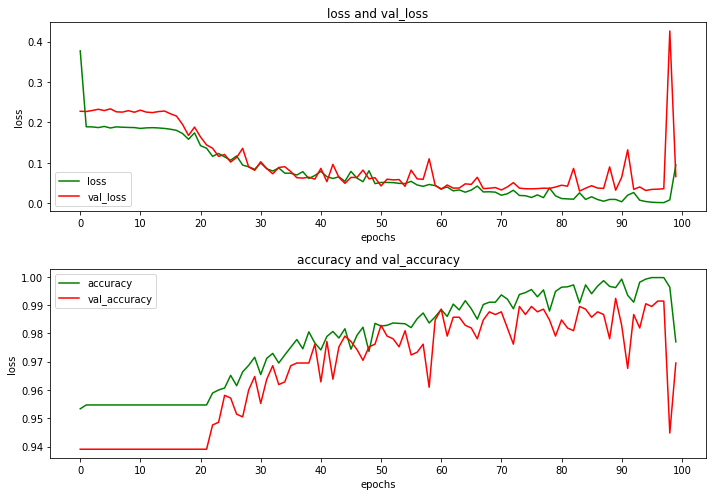

In [17]:
try:
    draw_loss(0, epochs, train_loss_total_list, val_loss_total_list, accuracy_train_total_list,
              accuracy_val_total_list)  # 画出训练曲线
except:
    pass

In [14]:
# 定义参数（调参只需要改这里即可，其他地方不用改）
n_class = 2  # 类别数。二分类问题，区分真假
batch_size = 128  # 每次训练的批次（太大可能会显存不够而报错，可调小再试）
dataset_name = 'female'  # 数据集的名字
dir_path = r'./datasets/%s' % dataset_name  # 数据集的路径
h, w = 64, 64  # 数据集图片的宽和高

In [15]:
# 加载数据集和预处理
dataloader = DataLoader(dataset_name=dataset_name, norm_range=(0, 1), img_res=(h, w))
x, y = dataloader.load_datasets(dir_path)
y_test_onehot = tf.one_hot(y_test, depth=n_class)  # 转为one_hot编码，用于分类
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
_, h, w, c = x_train.shape
test_db = tf.data.Dataset.from_tensor_slices((x_test, y_test_onehot)).batch(batch_size)

(7350, 64, 64, 3) (2100, 64, 64, 3) (7350,) (2100,)


In [16]:
# 搭建网络
model = VGG16(h, w, c, n_class, include_top=True)

VGG16层数: 36


In [17]:
# 加载模型
try:
    model.load_weights('model3.h5')
    print('已加载模型')
except:
    print('模型未加载！')

已加载模型


In [15]:
# 预测模型
t = time.time()
y_pred = model.predict(x_test)  # 预测
y_pred = np.argmax(y_pred, -1)
print('预测值:', y_pred.tolist())  # 列表里的每个数值，如果与真实值相同，说明这张图片的类别是预测对的
print('真实值:', y_test.tolist())
print('test_acc:', np.mean(np.equal(y_pred, y_test)), '耗时:%s秒' % (time.time() - t))  # 最后给出准确率结构。（后续会画混淆矩阵等等）

2022-12-21 21:56:57.355278: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101
2022-12-21 21:56:58.752958: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


预测值: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

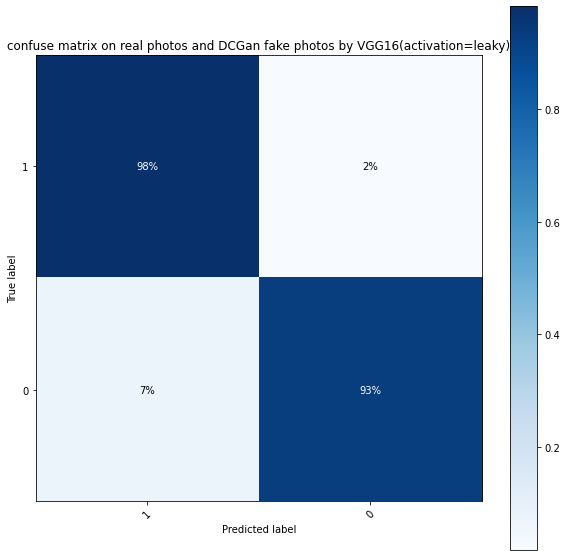

In [16]:
plot_matrix(y_test,y_pred,labels_name=[1,0],title='confuse matrix on real photos and DCGan fake photos by VGG16(activation=leaky)')

In [18]:
# 预测模型
t = time.time()
y_pred = model.predict(x_test)  # 预测
y_pred = np.argmax(y_pred, -1)
print('预测值:', y_pred.tolist())  # 列表里的每个数值，如果与真实值相同，说明这张图片的类别是预测对的
print('真实值:', y_test.tolist())
print('test_acc:', np.mean(np.equal(y_pred, y_test)), '耗时:%s秒' % (time.time() - t))  # 最后给出准确率结构。（后续会画混淆矩阵等等）

2022-12-25 17:43:36.705856: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101
2022-12-25 17:43:38.079258: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


预测值: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [19]:
print('测试集查准率:',precision_score(y_test,y_pred))
print('测试集召回率:',recall_score(y_test,y_pred))

测试集查准率: 0.9964467005076142
测试集召回率: 0.9829744616925388
